# **Loading the dataset**

New England as used in the 2017 Global Energy Forecasting Competition (GEFCom2017) as available from Cameron Roach's repository at Github: https://github.com/camroach87/gefcom2017data

In [1]:
pip install pyreadr

     |████████████████████████████████| 409 kB 9.4 MB/s eta 0:00:01


In [2]:
import requests
resp = requests.get("https://github.com/camroach87/gefcom2017data/raw/master/data/gefcom.rda", allow_redirects=True)
open('gefcom.rda', 'wb').write(resp.content)

6577272

In [3]:
import pyreadr
result = pyreadr.read_r('gefcom.rda')
df = result["gefcom"]

In [4]:
df.head()

,ts,zone,demand,drybulb,dewpnt,date,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday,trend
0,2003-03-01 00:00:00,CT,3386.0,25.0,19.0,2003-03-01,2003.0,Mar,1.0,Sat,60.0,True,NaN,False,0.0
1,2003-03-01 01:00:00,CT,3258.0,23.0,18.0,2003-03-01,2003.0,Mar,2.0,Sat,60.0,True,NaN,False,1.0
2,2003-03-01 02:00:00,CT,3189.0,22.0,18.0,2003-03-01,2003.0,Mar,3.0,Sat,60.0,True,NaN,False,2.0
3,2003-03-01 03:00:00,CT,3157.0,22.0,19.0,2003-03-01,2003.0,Mar,4.0,Sat,60.0,True,NaN,False,3.0
4,2003-03-01 04:00:00,CT,3166.0,23.0,19.0,2003-03-01,2003.0,Mar,5.0,Sat,60.0,True,NaN,False,4.0


In [5]:
df.zone.unique()

array(['CT', 'MASS', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'TOTAL',
       'VT', 'WCMASS'], dtype=object)

In [6]:
df.ts.dtypes

dtype('<M8[ns]')

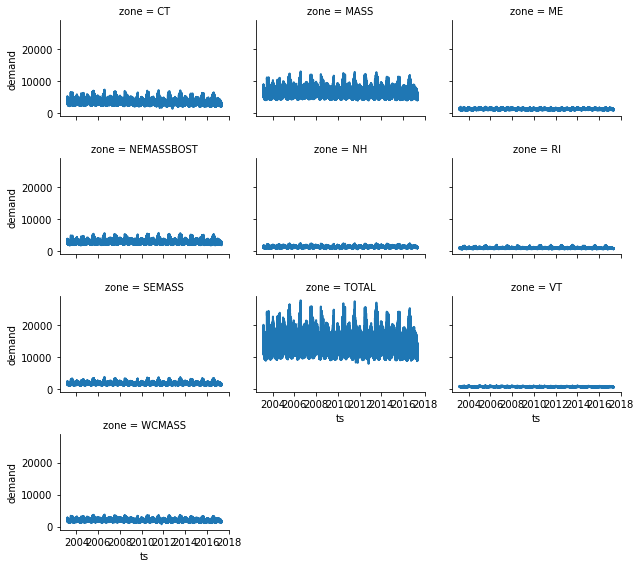

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.relplot(
    data=df,
    x="ts", y="demand", col="zone",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

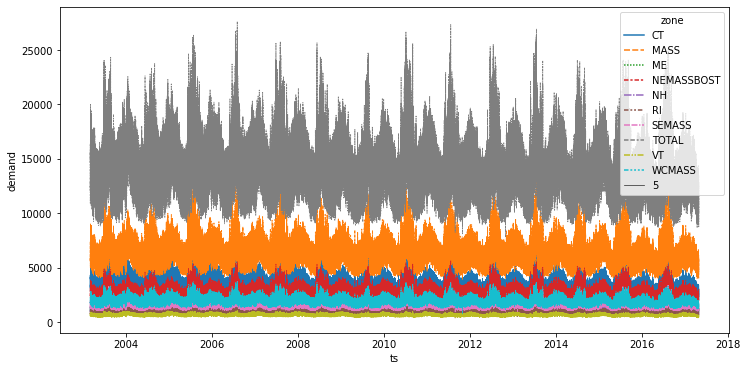

In [9]:
import matplotlib.pyplot as plt

plt.subplots(figsize=[12, 6])
sns.lineplot(
    data=df, x="ts", y="demand", hue="zone", style="zone", size=5,
    estimator=None, color=".7", linewidth=1,
)

In [13]:
dataset = df[
             df["zone"].isin(['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS',
                           'VT', 'WCMASS'])
             ]
# TOTAL and MASS are aggregated differently. We won't use these two "zones".

In [15]:
import pandas as pd

pivoted = dataset.pivot(index="ts", columns="zone", values="demand")

In [16]:
pivoted.head()

zone,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,
2003-03-01 00:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0
2003-03-01 01:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0
2003-03-01 02:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0
2003-03-01 03:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0
2003-03-01 04:00:00,3166.0,1077.0,2426.0,1010.0,740.0,1419.0,574.0,1750.0


In [17]:
dataset.columns

Index(['ts', 'zone', 'demand', 'drybulb', 'dewpnt', 'date', 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday', 'trend'],
      dtype='object')

In [26]:
dataset.columns
# The Dry Bulb, Wet Bulb and Dew Point temperatures are important to determine the state of humid air

Index(['ts', 'zone', 'demand', 'drybulb', 'dewpnt', 'date', 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday', 'trend'],
      dtype='object')

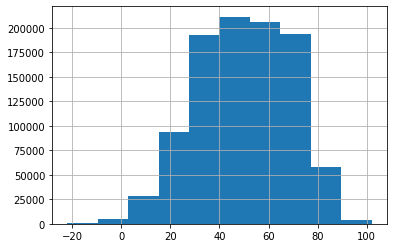

In [29]:
dataset.drybulb.hist()

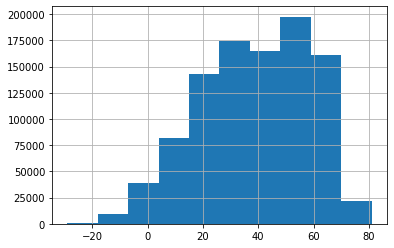

In [28]:
dataset.dewpnt.hist()

In [47]:
pivoted2 = pivoted.merge(dataset[["ts", 'year', 'month',
       'hour', 'day_of_week', 'day_of_year', 'weekend', 'holiday_name',
       'holiday']], on=["ts"], how="left").drop_duplicates()

In [48]:
T = len(pivoted2["ts"].unique())
split_t = pivoted2["ts"].unique()[T//10 * 8]
split_index = pivoted2["ts"] < split_t

In [60]:
train, test = pivoted2[split_index], pivoted2[~split_index]

In [61]:
len(test) / (len(train) + len(test))

0.20000644272817325

# Modeling

In [51]:
pivoted2.head()

,ts,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,year,month,hour,day_of_week,day_of_year,weekend,holiday_name,holiday
0,2003-03-01 00:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,2003.0,Mar,1.0,Sat,60.0,True,NaN,False
8,2003-03-01 01:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,2003.0,Mar,2.0,Sat,60.0,True,NaN,False
16,2003-03-01 02:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,2003.0,Mar,3.0,Sat,60.0,True,NaN,False
24,2003-03-01 03:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0,2003.0,Mar,4.0,Sat,60.0,True,NaN,False
32,2003-03-01 04:00:00,3166.0,1077.0,2426.0,1010.0,740.0,1419.0,574.0,1750.0,2003.0,Mar,5.0,Sat,60.0,True,NaN,False


In [112]:
pip install skits

In [353]:
from statsmodels.tsa.tsatools import lagmat

X = np.arange(1,7).reshape(-1,2)
# or: X = np.arange(2,7)
lagmat(X, maxlag=2, trim="forward", original='in')

array([[1., 2., 0., 0., 0., 0.],
       [3., 4., 1., 2., 0., 0.],
       [5., 6., 3., 4., 1., 2.]])

In [431]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from skits.preprocessing import DifferenceTransformer

from skits.pipeline import ForecasterPipeline
from skits.preprocessing import ReversibleImputer
from skits.feature_extraction import (AutoregressiveTransformer, 
                                      SeasonalTransformer)
#dt = DifferenceTransformer(period=4)
#Xt = dt.fit_transform(
#    train[['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']]
#)


pipeline = ForecasterPipeline([
    ("standard", StandardScaler()),                                                              
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline.fit(trained.values, trained.values)
y_pred = pipeline.predict(tested.values, to_scale=True, refit=True)

In [432]:
mean_squared_error([y_pred[0, 0]], [tested.values[0, 0]], squared=False)

180.00741234320137

In [433]:
mean_squared_error(y_pred, tested.values, squared=False)

144.55312165945753

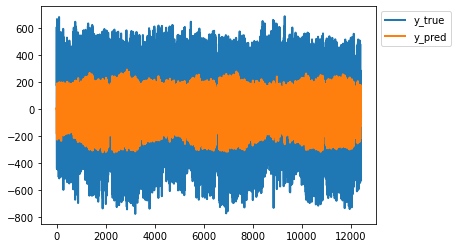

In [434]:
import matplotlib.pyplot as plt

plt.plot(tested.values[:, 0], lw=2)
plt.plot(y_pred[:, 0], lw=2)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));

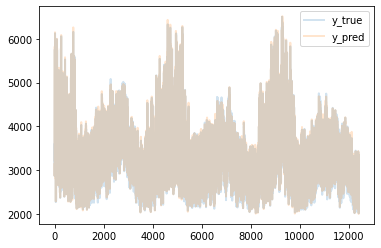

In [443]:
plt.plot(test.values[:, 0], lw=2, alpha=0.2)
plt.plot(test.values[1:-1, 0] + y_pred[:, 0], lw=2, alpha=0.2)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));

In [444]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', DecisionTreeRegressor())
])

pipeline.fit(trained.values, trained.values)
y_pred = pipeline.predict(tested.values, to_scale=True, refit=True)

In [445]:
mean_squared_error(y_pred, tested.values, squared=False)

136.23989747634855

In [446]:
mean_squared_error([y_pred[0, 0]], [tested.values[0, 0]], squared=False)

35.0

In [447]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pipeline = ForecasterPipeline([
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=3)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('regressor', MultiOutputRegressor(XGBRegressor(random_state=0), n_jobs=-1))
])

pipeline.fit(trained.values, trained.values)
y_pred = pipeline.predict(tested.values, to_scale=True, refit=True)

In [448]:
mean_squared_error(y_pred, tested.values, squared=False)

104.08197535801648

In [449]:
mean_squared_error([y_pred[0, 0]], [tested.values[0, 0]], squared=False)

365.1485137939453

In [ ]:
pip install catboost

In [436]:
set(train.columns)

{'CT',
 'ME',
 'NEMASSBOST',
 'NH',
 'RI',
 'SEMASS',
 'VT',
 'WCMASS',
 'day_of_year',
 'holiday',
 'hour',
 'weekend',
 'year'}

In [451]:
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer

train, test = pivoted[split_index], pivoted2[~split_index]

pipeline = ForecasterPipeline([
    #("impute", SimpleImputer(strategy="constant", fill_value=-9999)),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=4)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    #('regressor', MultiOutputRegressor(CatBoostRegressor(random_state=0), n_jobs=-1))
    ('regressor', CatBoostRegressor(loss_function="MultiRMSE"))
])
pipeline.fit(trained.values, trained.values)
y_pred = pipeline.predict(tested.values, to_scale=False, refit=True)

0:	learn: 500.1663413	total: 35.6ms	remaining: 35.6s
1:	learn: 491.8111752	total: 77.1ms	remaining: 38.5s
2:	learn: 484.0717771	total: 111ms	remaining: 36.7s
3:	learn: 476.6542145	total: 143ms	remaining: 35.7s
4:	learn: 469.9241838	total: 176ms	remaining: 35s
5:	learn: 463.1996588	total: 208ms	remaining: 34.4s
6:	learn: 456.7792328	total: 244ms	remaining: 34.6s
7:	learn: 450.1249539	total: 282ms	remaining: 34.9s
8:	learn: 443.9356253	total: 314ms	remaining: 34.6s
9:	learn: 437.7674061	total: 348ms	remaining: 34.4s
10:	learn: 431.9263816	total: 386ms	remaining: 34.7s
11:	learn: 426.5019053	total: 419ms	remaining: 34.5s
12:	learn: 421.4211163	total: 455ms	remaining: 34.6s
13:	learn: 416.5004472	total: 495ms	remaining: 34.8s
14:	learn: 411.4926743	total: 528ms	remaining: 34.7s
15:	learn: 406.7335280	total: 562ms	remaining: 34.6s
16:	learn: 402.4292638	total: 596ms	remaining: 34.4s
17:	learn: 398.2192721	total: 628ms	remaining: 34.3s
18:	learn: 393.9893100	total: 675ms	remaining: 34.9s
19:

In [452]:
MAXLAGS = 4

target_columns = ['CT', 'ME', 'NEMASSBOST', 'NH', 'RI', 'SEMASS', 'VT', 'WCMASS']
colnames = target_columns * MAXLAGS
lagged = pd.DataFrame(data=lagmat(pivoted, maxlag=MAXLAGS, trim="forward", original='ex'), columns=colnames, index=pivoted.index).join(train[[]])
lagged.head()

,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS,CT,ME,NEMASSBOST,NH,RI,SEMASS,VT,WCMASS
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-03-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 01:00:00,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 02:00:00,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 03:00:00,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-03-01 04:00:00,3157.0,1050.0,2420.0,997.0,737.0,1401.0,570.0,1740.0,3189.0,1053.0,2426.0,1000.0,741.0,1407.0,578.0,1761.0,3258.0,1063.0,2477.0,1017.0,760.0,1432.0,587.0,1795.0,3386.0,1111.0,2574.0,1055.0,791.0,1484.0,608.0,1855.0


In [454]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

split_index = lagged.index < split_t
training = lagged[split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = training[[c for c in training.columns if c not in target_columns]], training[[c for c in training.columns if c in target_columns]]

pipeline = make_pipeline(StandardScaler(), CatBoostRegressor(loss_function="MultiRMSE"))
pipeline.fit(X, y)
testing = lagged[~split_index].join(pivoted, how="left", lsuffix="_lag")
X, y = testing[[c for c in testing.columns if c not in target_columns]], testing[[c for c in testing.columns if c in target_columns]]
forecast = pipeline.predict(X)
print(f"MSE all data: {mean_squared_error(y.values, forecast, squared=False)}")
print(f"MSE first point: {mean_squared_error([y.values[0, 0]], [forecast[0, 0]], squared=False)}")

0:	learn: 1167.6276143	total: 625ms	remaining: 10m 24s
1:	learn: 1137.7566574	total: 1.17s	remaining: 9m 42s
2:	learn: 1108.8696510	total: 1.73s	remaining: 9m 35s
3:	learn: 1080.7095940	total: 2.28s	remaining: 9m 27s
4:	learn: 1053.6525844	total: 2.83s	remaining: 9m 22s
5:	learn: 1027.3317924	total: 3.38s	remaining: 9m 20s
6:	learn: 1001.8117388	total: 3.94s	remaining: 9m 19s
7:	learn: 977.1431968	total: 4.48s	remaining: 9m 16s
8:	learn: 953.5483974	total: 5.07s	remaining: 9m 18s
9:	learn: 930.3806973	total: 5.62s	remaining: 9m 16s
10:	learn: 907.8368348	total: 6.17s	remaining: 9m 14s
11:	learn: 886.1815588	total: 6.72s	remaining: 9m 13s
12:	learn: 865.1147136	total: 7.25s	remaining: 9m 10s
13:	learn: 844.6734539	total: 7.82s	remaining: 9m 10s
14:	learn: 824.8133956	total: 8.36s	remaining: 9m 8s
15:	learn: 805.8165671	total: 9s	remaining: 9m 13s
16:	learn: 786.9838657	total: 9.54s	remaining: 9m 11s
17:	learn: 768.9522987	total: 10.1s	remaining: 9m 10s
18:	learn: 751.7808768	total: 10.7

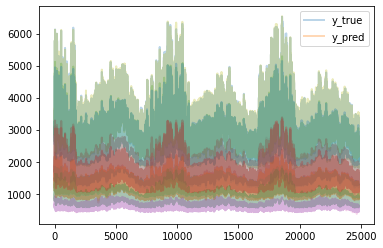

In [455]:
plt.plot(y.values, lw=2, alpha=0.3)
plt.plot(forecast, lw=2, alpha=0.3)
plt.legend(['y_true', 'y_pred'], bbox_to_anchor=(1, 1));